In [117]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Example code to walk through directories and print file names
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [118]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [119]:
df_train = df_train.drop(columns=["id"])

# Understanding The Dataset

In [120]:
df_train.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [121]:
print("Shape: ", df_train.shape)

Shape:  (58645, 12)


## Exploring the Dataset

### Stacked Bar Plot of Loan Intent

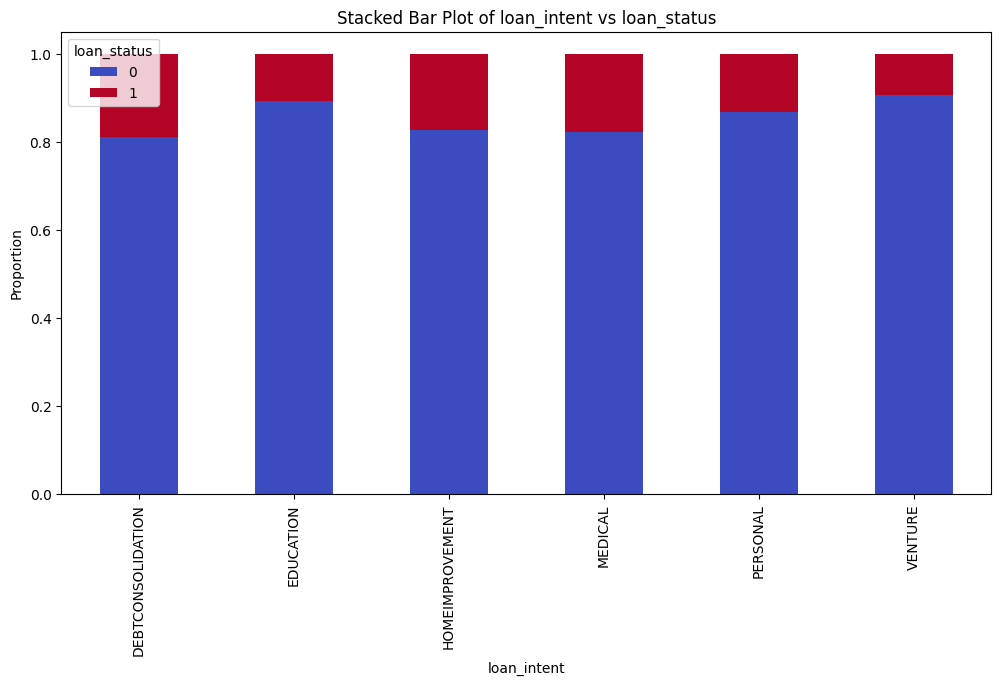

In [122]:
def stacked_bar_plot(df, feature, target='loan_status'):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='coolwarm')
    plt.title(f'Stacked Bar Plot of {feature} vs {target}')
    plt.ylabel('Proportion')
    plt.show()

stacked_bar_plot(df_train, 'loan_intent')

### Stacked Bar Plot of Home Ownership


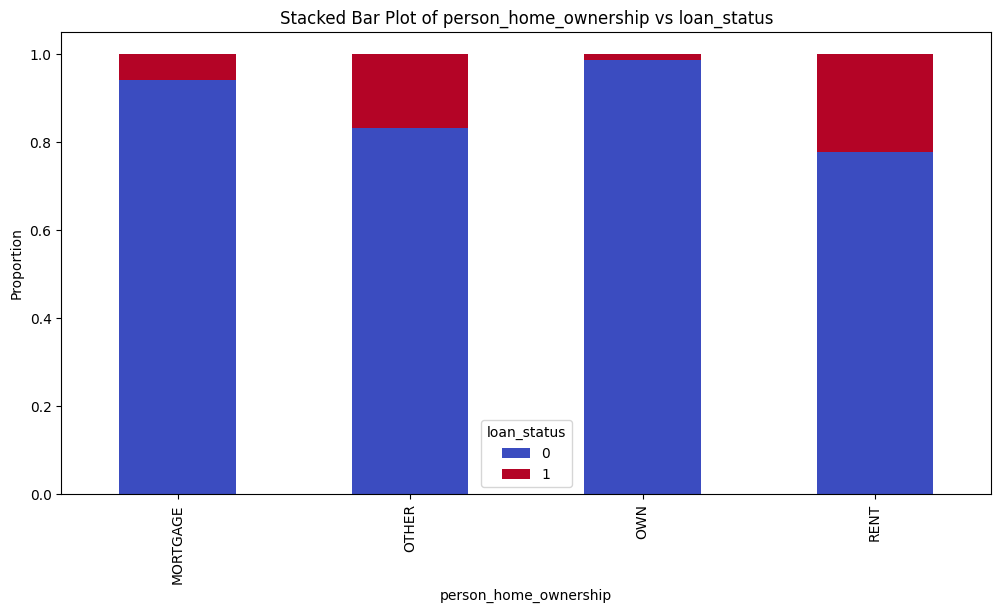

In [123]:
stacked_bar_plot(df_train, 'person_home_ownership')

### Distribution of Numerical Features

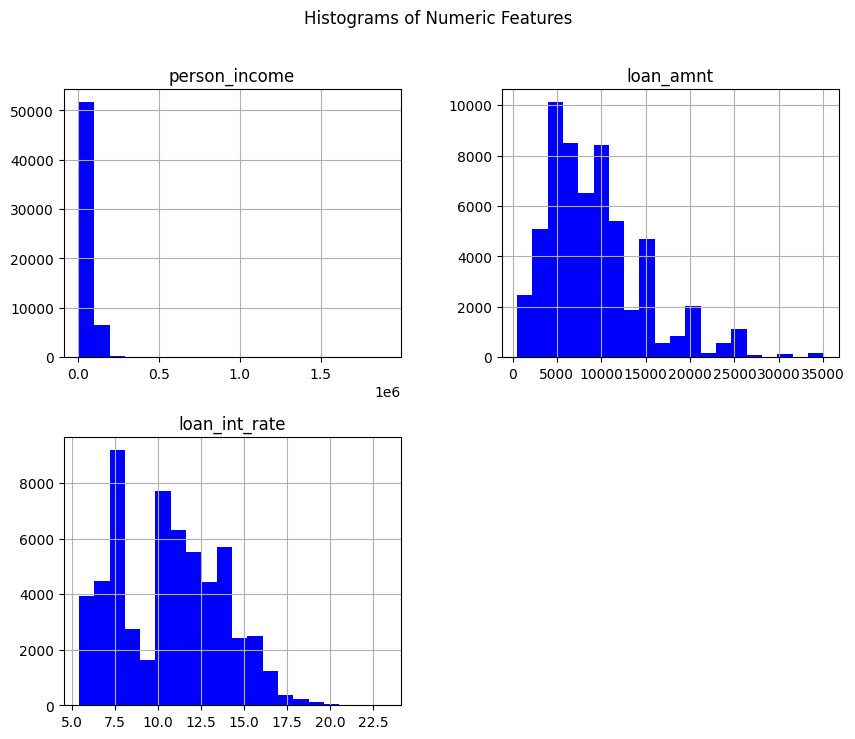

In [124]:
numeric_features = ['person_income', 'loan_amnt', 'loan_int_rate']

df_train[numeric_features].hist(figsize=(10, 8), bins=20, color='blue')
plt.suptitle('Histograms of Numeric Features')
plt.show()

### Box Plots for Outlier Detection

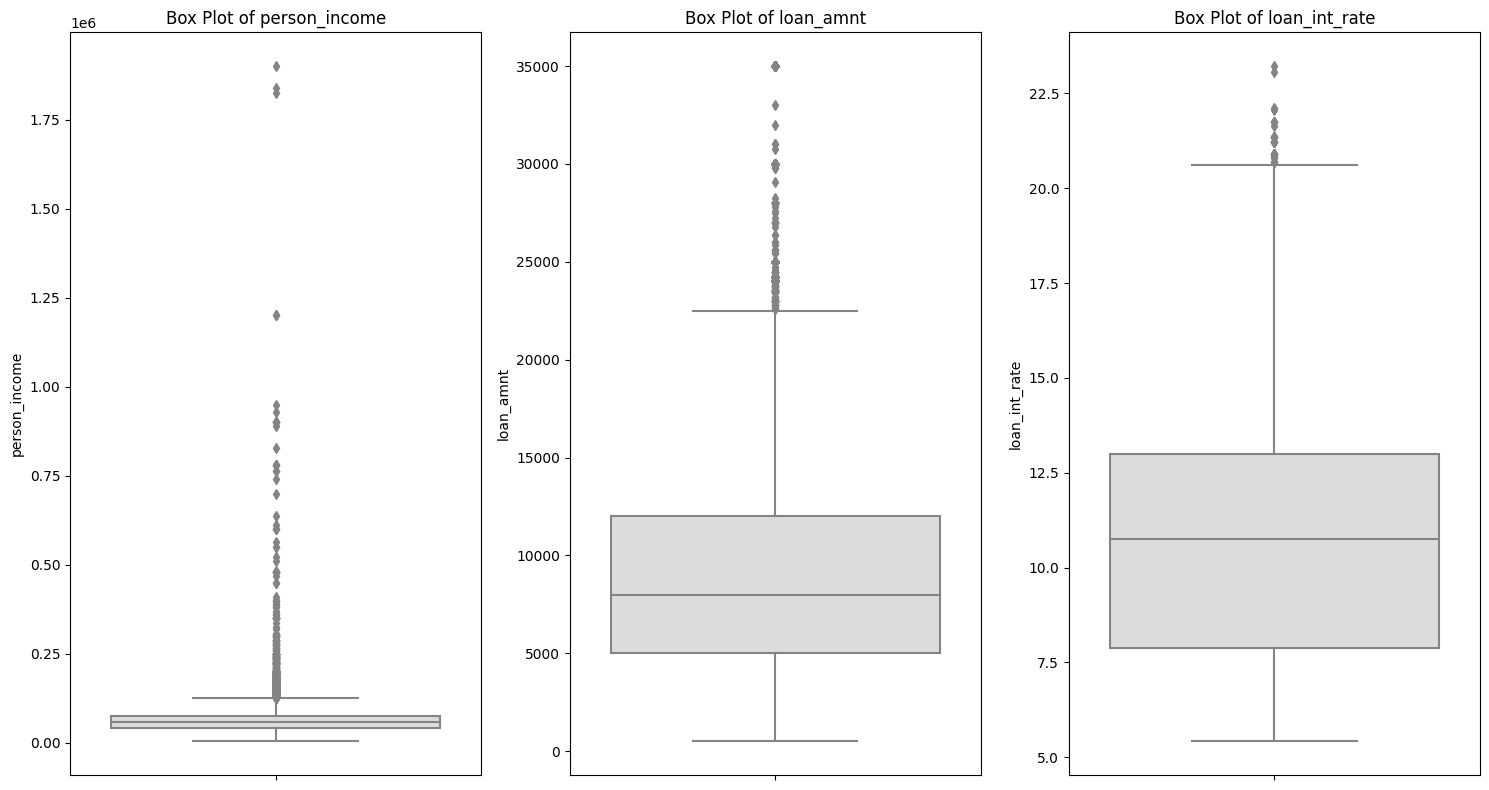

In [125]:
plt.figure(figsize=(15, 8))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_train[feature], palette="coolwarm")
    plt.title(f'Box Plot of {feature}')
    plt.tight_layout()

plt.show()


### Loan Amount vs Interest Rate Scatter Plot

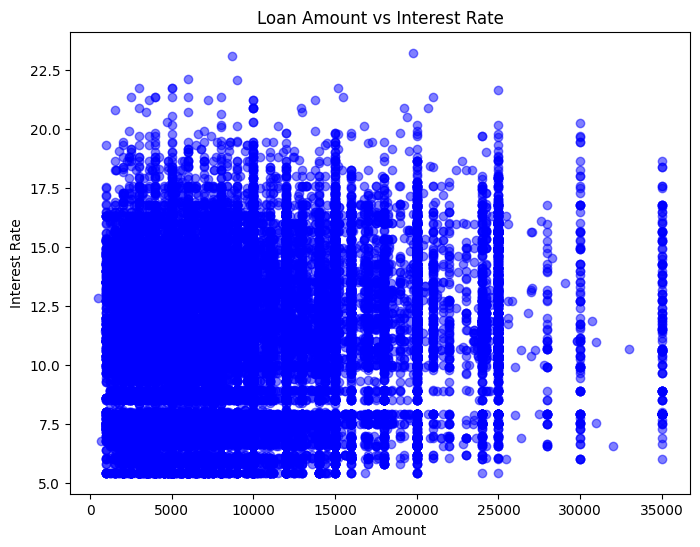

In [126]:
plt.figure(figsize=(8, 6))
plt.scatter(df_train['loan_amnt'], df_train['loan_int_rate'], alpha=0.5, c='blue')
plt.title('Loan Amount vs Interest Rate')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.show()

In [127]:
le_person_home_ownership = LabelEncoder()
le_loan_intent = LabelEncoder()
le_loan_grade = LabelEncoder()
le_cb_person_default_on_file = LabelEncoder()

# Apply the LabelEncoder to each categorical column
df_train['person_home_ownership'] = le_person_home_ownership.fit_transform(df_train['person_home_ownership'])
df_train['loan_intent'] = le_loan_intent.fit_transform(df_train['loan_intent'])
df_train['loan_grade'] = le_loan_grade.fit_transform(df_train['loan_grade'])
df_train['cb_person_default_on_file'] = le_cb_person_default_on_file.fit_transform(df_train['cb_person_default_on_file'])

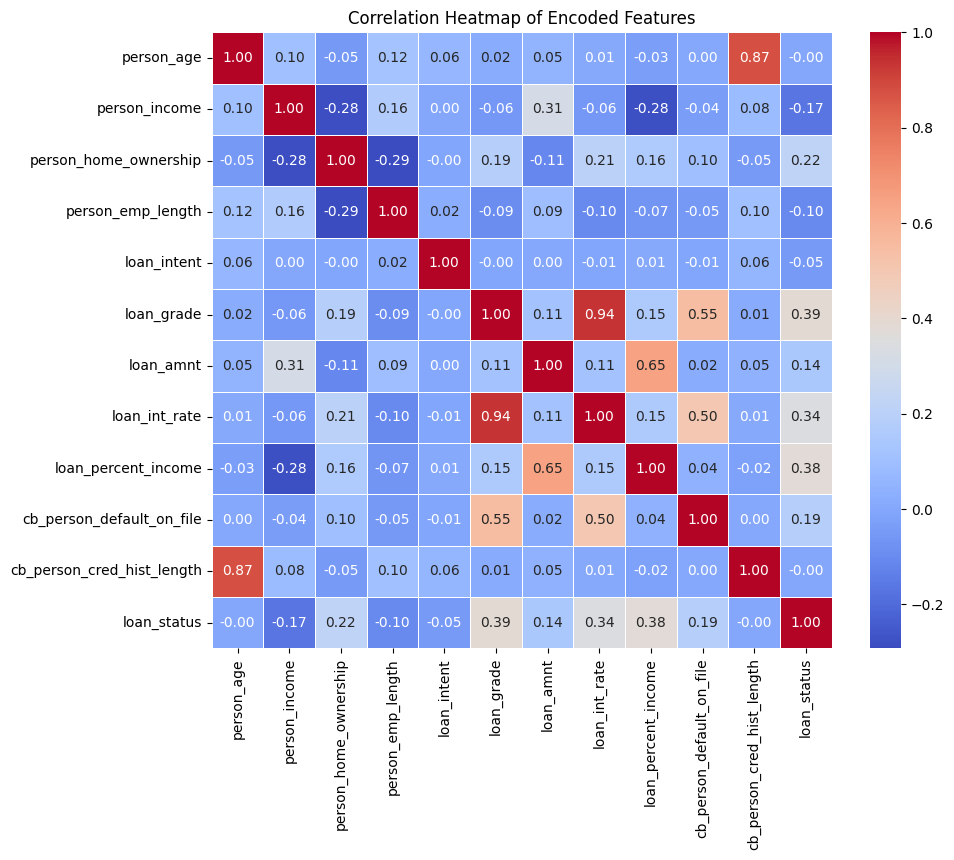

In [128]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Encoded Features')
plt.show()

## Splitting Dataset

In [129]:
# Creating the target
x = df_train.drop(columns=['loan_status'])
y = df_train['loan_status']

In [130]:
# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# XGBoost Baseline

In [131]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = xgb_model.predict_proba(X_test)[:, 1]

## ROC Curve

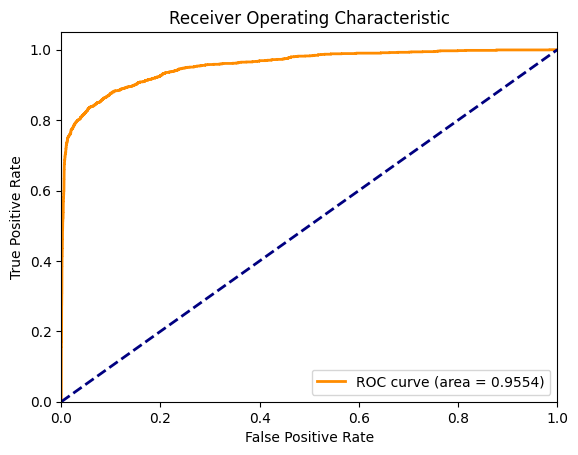

In [132]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Validation

## Preparing the Dataset

In [133]:
testids = df_test["id"]
df_test = df_test.drop(columns=["id"])
df_test.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [134]:
# Transform the test data using the fitted encoders from the training data
df_test['person_home_ownership'] = le_person_home_ownership.transform(df_test['person_home_ownership'])
df_test['loan_intent'] = le_loan_intent.transform(df_test['loan_intent'])
df_test['loan_grade'] = le_loan_grade.transform(df_test['loan_grade'])
df_test['cb_person_default_on_file'] = le_cb_person_default_on_file.transform(df_test['cb_person_default_on_file'])

# Submission

In [135]:
testpred = xgb_model.predict_proba(df_test)[:, 1]
predictions_df = pd.DataFrame({
    'id': testids,
    'predictions': testpred
})

In [136]:
predictions_df.to_csv('submission.csv', index=False)